In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
#%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!


sns.set() # better looking figs



In [3]:
df = pd.read_csv("questionnaire-answers-per-clip.csv")
df

,Unnamed: 0,clipName,pptID,condition,gettingOnWell,relationshipBetweenCharacters,workingTogether,leftDominant,rightDominant,leftCooperative,...,leftFearful,rightFearful,leftSad,rightSad,leftContent,rightContent,leftAngry,rightAngry,leftAmused,rightAmused
0,0,1Laugh1PushAway,55,4,0.0,0.0,0.0,4.0,4.0,4.0,...,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
1,1,1Laugh1PushAway,87,4,1.0,0.0,2.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.0
2,2,1Laugh1PushAway,118,2,0.0,0.0,0.0,1.0,3.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
3,3,1Laugh1PushAway,136,2,2.0,0.0,2.0,1.0,3.0,1.0,...,2.0,1.0,2.0,2.0,1.0,1.0,1.0,3.0,2.0,2.0
4,4,1Laugh1PushAway,417,4,2.0,2.0,2.0,2.0,3.0,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,3.0,3.0,1.0
5,5,1Laugh1PushAway,681,4,1.0,1.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,4.0,2.0
6,6,1Laugh1PushAway,695,4,0.0,0.0,1.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,3.0
7,7,1Laugh1PushAway,1031,4,2.0,2.0,2.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,3.0,1.0
8,8,1Laugh1PushAway,1315,4,1.0,0.0,0.0,0.0,4.0,0.0,...,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,1.0
9,9,1Laugh1PushAway,1460,2,0.0,0.0,0.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0


## PCA for dimensionality reduction

In [4]:
from sklearn.decomposition import PCA

In [5]:
skel_df=df[df["condition"]==2] # skeleton only
skel=skel_df.T.iloc[4:].T.values
skel_means=skel_df.groupby(["clipName"]).mean().T.iloc[3:].T
skel_labels=skel_df["clipName"].values

fullscene_df=df[df["condition"]==4] # full scene
fullscene=fullscene_df.T.iloc[4:].T.values
fullscene_means=fullscene_df.groupby(["clipName"]).mean().T.iloc[3:].T
fullscene_labels=fullscene_df["clipName"].values

In [6]:
skel


array([[0.0, 0.0, 0.0, ..., 0.0, 4.0, 3.0],
       [2.0, 0.0, 2.0, ..., 3.0, 2.0, 2.0],
       [0.0, 0.0, 0.0, ..., 0.0, 4.0, 4.0],
       ...,
       [0.0, 0.0, 0.0, ..., 1.0, 2.0, 2.0],
       [0.0, 0.0, 0.0, ..., 1.0, 1.0, 1.0],
       [0.0, 0.0, 0.0, ..., 1.0, 4.0, 3.0]], dtype=object)

In [7]:
pca=PCA(n_components=6)
pca.fit(skel)

skel_pca = pca.transform(skel)
skel_means_pca = pca.transform(skel_means.values)

fullscene_pca = pca.transform(fullscene)
fullscene_means_pca = pca.transform(fullscene_means.values)

## Plotting of the embeding

`plot_embedding` plots each questionnaire's response when projected along the first 2 eigenvectors. Responses' colours correspond to the clips.

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')
    
def plot_embedding(X, labels, means=None, means_labels=None, clusters=None, three_d=False):

    markers = ["o","x","s","v", "*", "^",">","<","8","p","D"]
    
    plt.figure()
    
    labels = np.array(labels) # needed for masking with plotting with clusters    
    colors = np.array([list(set(labels)).index(l) for l in labels])
    
    if means_labels is not None:
        colors_means = [sns.color_palette("tab20",20)[list(set(labels)).index(l)] for l in means_labels]
    
    handles=[]
    if three_d:
        ax = plt.subplot(111, projection='3d')
        if clusters is not None:
            for cluster in set(clusters):
                mask = clusters == cluster
                ax.scatter(X[mask, 0], X[mask, 1], X[mask,2], marker=markers[cluster], c=colors[mask], label=labels[mask], cmap=plt.get_cmap("tab20"))
        else:
            ax.scatter(X[:, 0], X[:, 1], X[:,2], marker=clusters_markers, c=colors, label=labels, cmap=plt.get_cmap("tab20"))
            
        ax.set_zlabel('3rd component')
        
        if means is not None:
            for i in range(means.shape[0]):
                points=ax.scatter(means[i, 0], means[i, 1], means[i,2], marker="o", s=200, c=colors_means[i], label=means_labels[i])
                handles.append(points)
            
    else:
        ax = plt.subplot(111)
        if clusters is not None:
            for cluster in set(clusters):
                mask = clusters == cluster
                ax.scatter(X[mask, 0], X[mask, 1], marker=markers[cluster], c=colors[mask], label=labels[mask], cmap=plt.get_cmap("tab20"))
        else:
            ax.scatter(X[:, 0], X[:, 1], marker="o", c=colors[:], label=labels[:], cmap=plt.get_cmap("tab20"))
        
        if means is not None:
            for i in range(means.shape[0]):
                points=ax.scatter(means[i, 0], means[i, 1], marker="o", s=200, c=colors_means[i], label=means_labels[i])
                handles.append(points)
            

    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')

    if means is not None:
        ax.legend(handles, means_labels, loc=1, prop=fontP)
        
def plot_compare_embeddings(X, Y, labels, three_d=False):

    plt.figure()
    labels = np.array(labels) # needed for masking with plotting with clusters
    
    colors = np.array([sns.color_palette("tab20",20)[list(labels).index(l)] for l in labels])
    
    handles=[]
    
    if three_d:
        ax = plt.subplot(111, projection='3d')
        
        for i in range(X.shape[0]):
            points=ax.scatter(X[i, 0], X[i, 1], X[i,2], marker="o", s=200, c=colors[i], label=labels[i])
            handles.append(points)
            points=ax.scatter(Y[i, 0], Y[i, 1], Y[i,2], marker="x", s=200, c=colors[i], label=labels[i])
            
            ax.plot((X[i,0], Y[i,0]), (X[i,1], Y[i,1]), (X[i,2], Y[i,2]), '-',c=colors[i])
            
        ax.set_zlabel('3rd component')
        #ax.set_zlim(-3,3)
            
    else:
        ax = plt.subplot(111)
        
        for i in range(X.shape[0]):
            points=ax.scatter(X[i, 0], X[i, 1], marker="o", s=200, c=colors[i], label=labels[i])
            handles.append(points)
            ax.scatter(Y[i, 0], Y[i, 1], marker="x", s=200, c=colors[i], label=labels[i])
            
            ax.plot((X[i,0], Y[i,0]), (X[i,1], Y[i,1]), '-',c=colors[i])
                       

    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    
    #ax.set_xlim(-3,3)
    #ax.set_ylim(-3,3)
    

    ax.legend(handles, labels, loc='best', prop=fontP)
    ax.set_title("O: skel (skeletons), X: fullscene (full scene)")
    

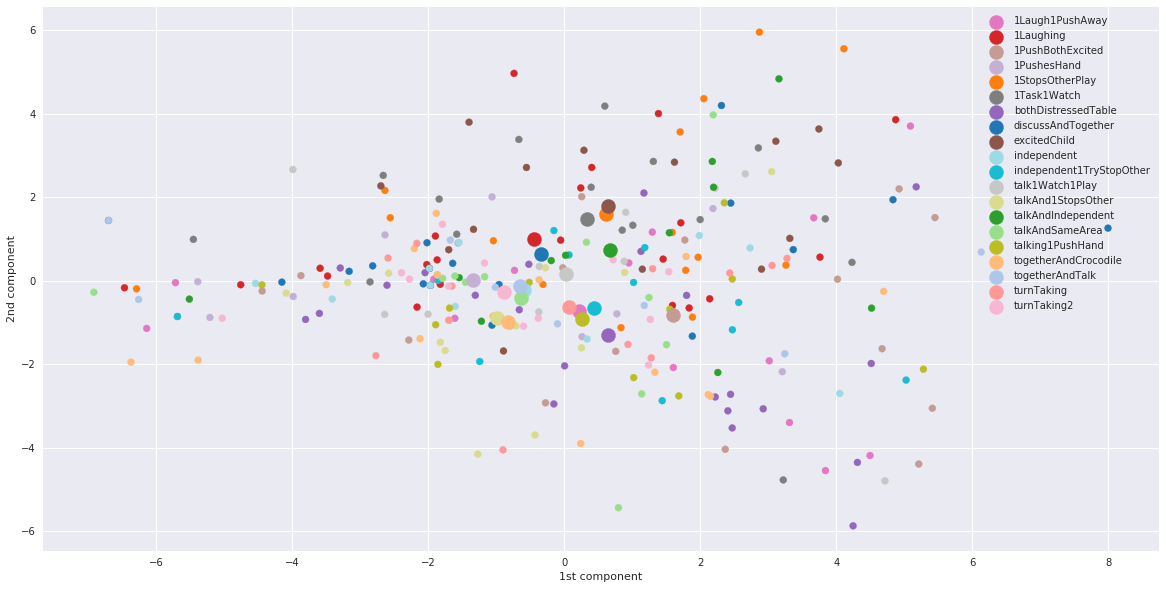

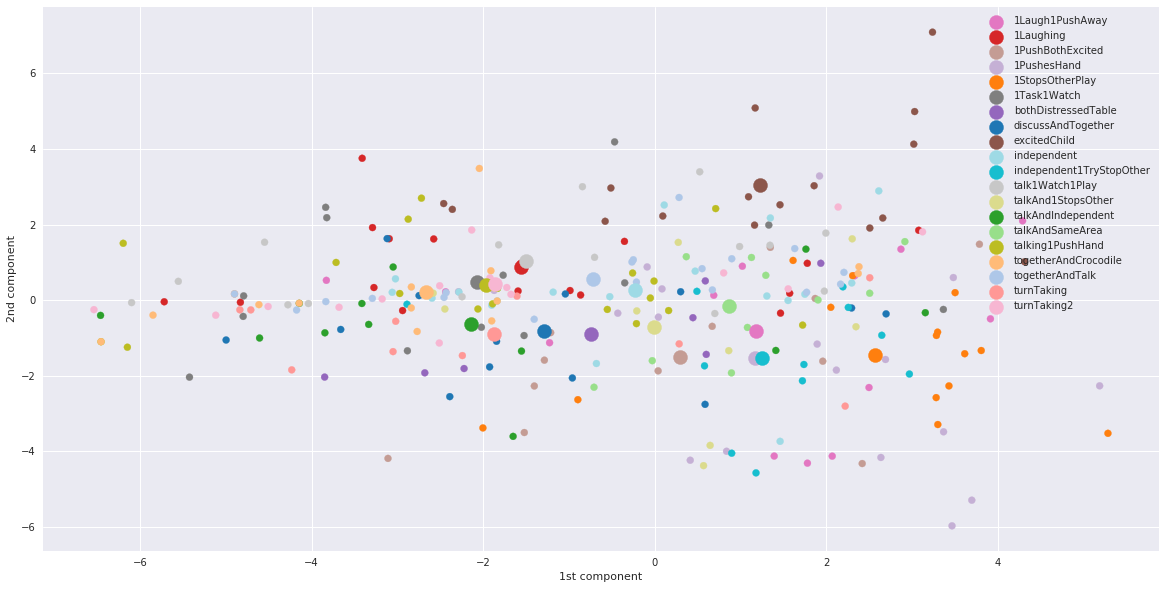

In [9]:
plot_embedding(skel_pca, skel_labels, skel_means_pca, skel_means.index, three_d=False) 
plot_embedding(fullscene_pca, fullscene_labels, fullscene_means_pca, fullscene_means.index, three_d=False)

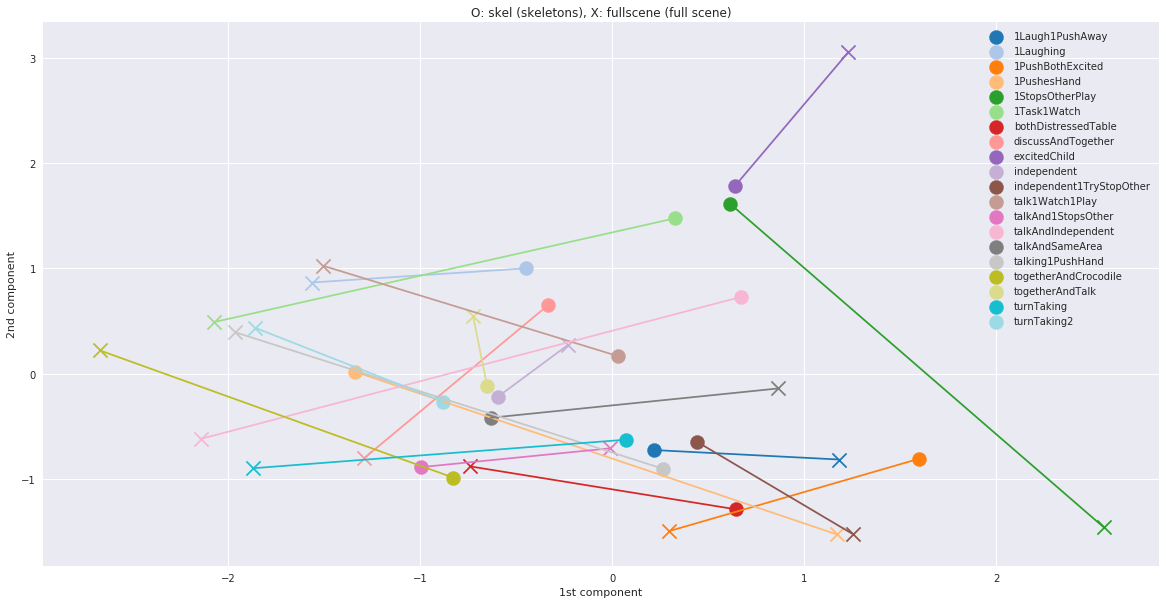

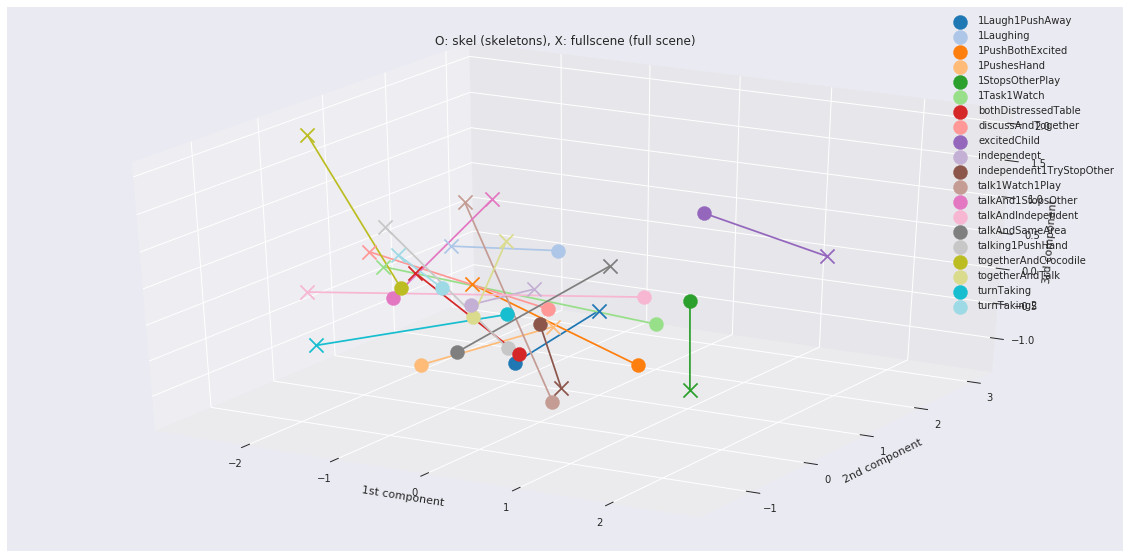

In [10]:
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index,three_d=False)
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index,three_d=True)

In [11]:
distances_pca=pd.DataFrame(np.power(np.sum(np.power(skel_means_pca - fullscene_means_pca, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_pca"])
distances_pca

,distance_pca
clipName,
1Laugh1PushAway,1.627761
1Laughing,1.352605
1PushBothExcited,2.132483
1PushesHand,3.407838
1StopsOtherPlay,3.773486
1Task1Watch,2.934082
bothDistressedTable,2.335876
discussAndTogether,2.395046
excitedChild,1.798807


In [12]:
pca.explained_variance_ratio_.cumsum()

array([0.28405715, 0.41658333, 0.51708521, 0.57579546, 0.62923102,
       0.67070969])

In [13]:
pca.components_


array([[ 0.17548592,  0.15016615,  0.14538466,  0.05376097,  0.13633354,
        -0.21093684, -0.2386643 ,  0.17641636,  0.23302474, -0.21699709,
        -0.25971502,  0.19025137,  0.27863681, -0.15274028, -0.11062468,
         0.20882575,  0.18131997,  0.18626668,  0.16037721, -0.23449424,
        -0.24284952,  0.2457872 ,  0.30775015, -0.14672371, -0.16033606],
       [ 0.01357949,  0.01438256,  0.02452207,  0.42994249, -0.41896846,
        -0.18209335,  0.0747369 ,  0.32136526, -0.2173944 , -0.13951877,
         0.07173952,  0.3495939 , -0.24967575,  0.0014334 , -0.1105479 ,
        -0.21517212,  0.26782144, -0.12600513,  0.1804615 ,  0.07111757,
        -0.04827713,  0.15283523, -0.13380643,  0.10641266,  0.03883441],
       [-0.14391971, -0.11048205, -0.18594399,  0.05503047,  0.2185336 ,
         0.13508949,  0.12723342,  0.30134902,  0.27324022,  0.21053698,
         0.21047521,  0.22557171,  0.28653153,  0.08431671,  0.12230118,
         0.19236272,  0.16733776,  0.12434086,  0

## LDA

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [15]:
lda = LinearDiscriminantAnalysis(n_components=4)
lda.fit(skel_pca, skel_labels)

# we perform the LDA *on top of the PCA* as LDA typically requires O > 3 F, with O the nb of observations and F the nb of features (here, we have ~26 observations for originally 25 questions)
skel_lda = lda.transform(pca.transform(skel))
skel_means_lda = lda.transform(pca.transform(skel_means.values))

fullscene_lda = lda.transform(pca.transform(fullscene))
fullscene_means_lda = lda.transform(pca.transform(fullscene_means.values))


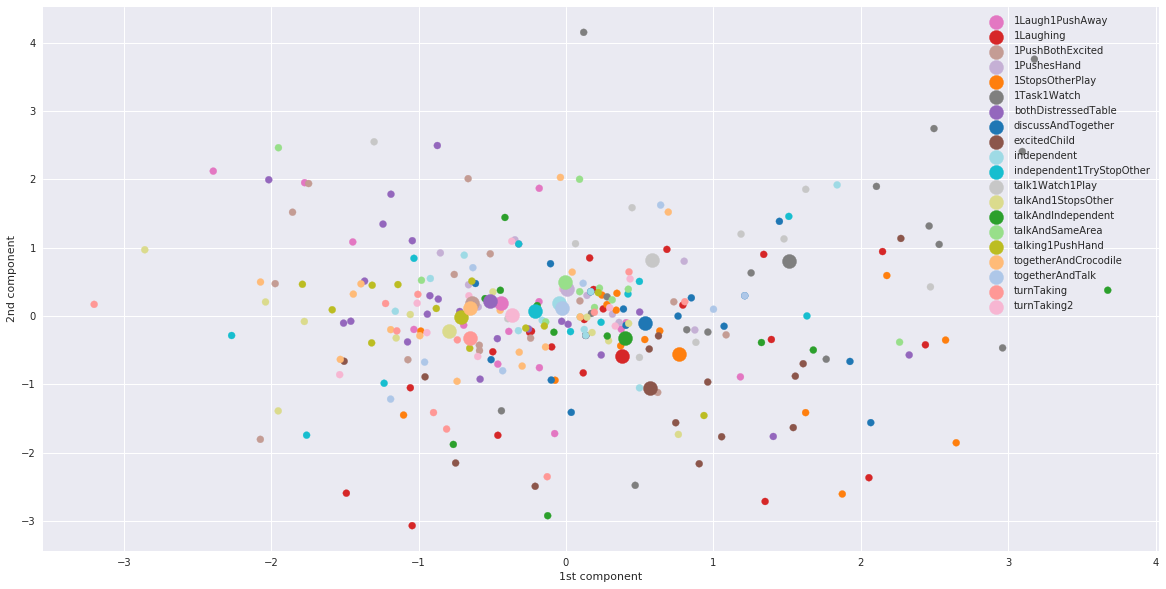

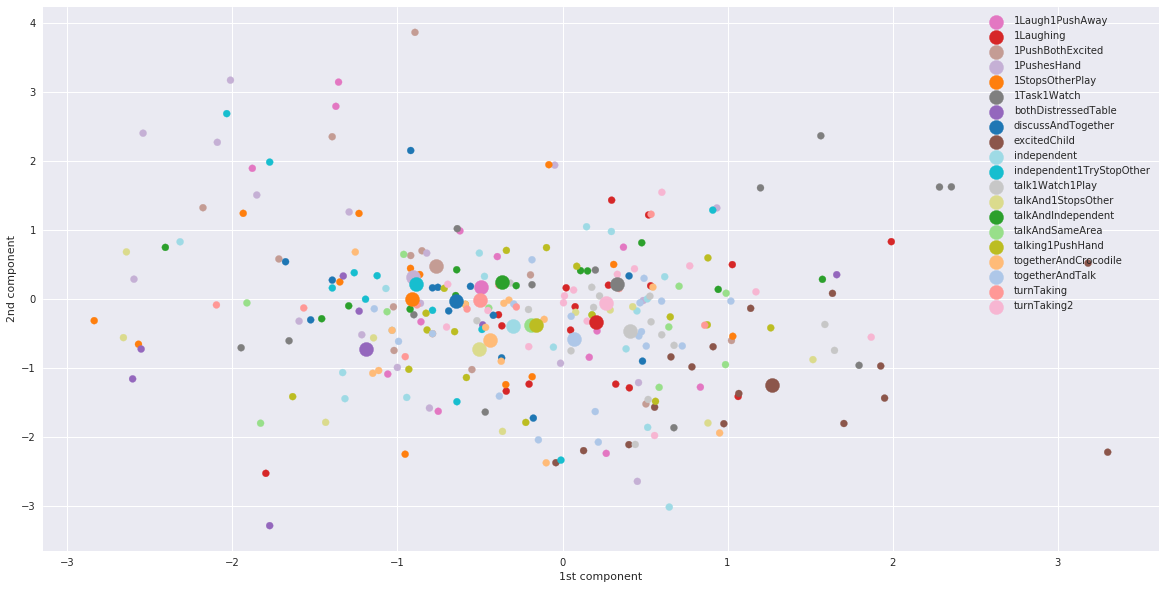

In [16]:
plot_embedding(skel_lda, skel_labels,skel_means_lda, skel_means.index, three_d=False)
plot_embedding(fullscene_lda, fullscene_labels,fullscene_means_lda, fullscene_means.index, three_d=False)

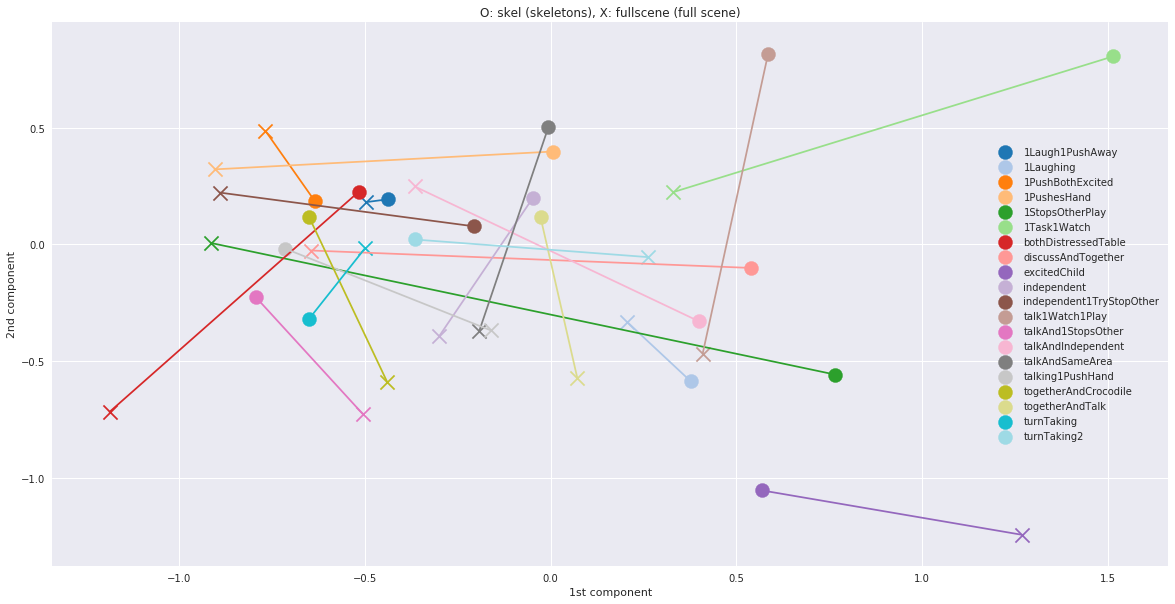

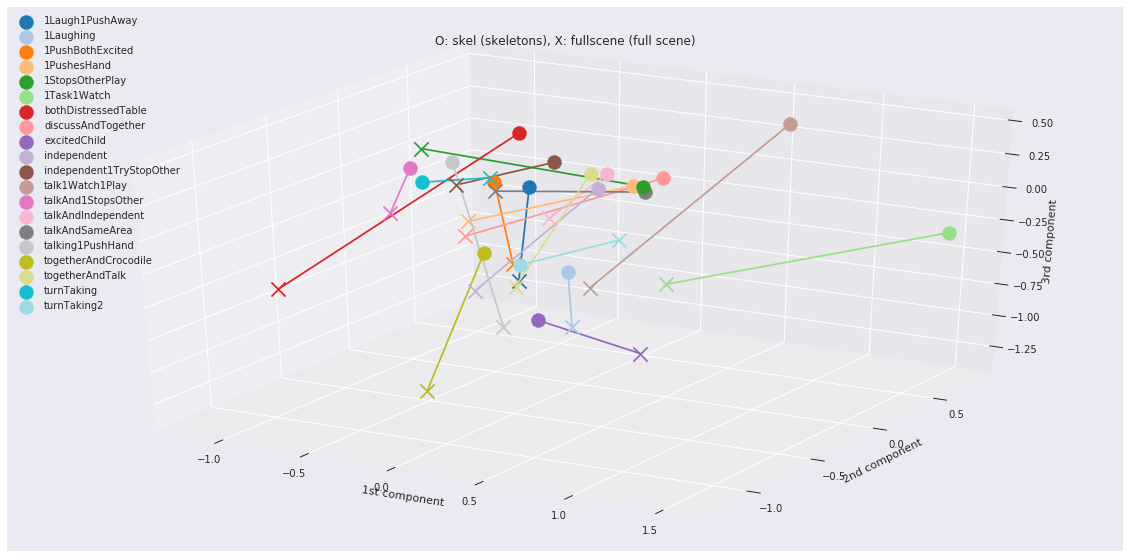

In [17]:
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=False)
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=True)

In [18]:
distances_lda=pd.DataFrame(np.power(np.sum(np.power(skel_means_lda - fullscene_means_lda, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_lda"])


In [19]:
distances = pd.concat([distances_pca, distances_lda], axis=1)
s = distances.style.background_gradient(cmap="summer")
s


,distance_pca,distance_lda
clipName,,
1Laugh1PushAway,1.62776,0.789445
1Laughing,1.3526,0.698463
1PushBothExcited,2.13248,1.169
1PushesHand,3.40784,1.15119
1StopsOtherPlay,3.77349,1.86058
1Task1Watch,2.93408,1.37355
bothDistressedTable,2.33588,1.5393
discussAndTogether,2.39505,1.40226
excitedChild,1.79881,0.724966


## Explorative Factor Analysis

In [20]:
import factor_analyzer


In [21]:
skel_ratings_df=skel_df.T.iloc[7:].T.astype(float)
fullscene_ratings_df=fullscene_df.T.iloc[7:].T.astype(float)

In [22]:
fa_skel = factor_analyzer.FactorAnalyzer()
fa_skel.analyze(skel_ratings_df,6,rotation=None)
skel_loadings=fa_skel.loadings

fa_fullscene = factor_analyzer.FactorAnalyzer()
fa_fullscene.analyze(fullscene_ratings_df,6,rotation=None)
fullscene_loadings=fa_fullscene.loadings

In [23]:
# merge loadings into one dataframe, skel and fullscene side-by-side
loadings=pd.concat([skel_loadings, fullscene_loadings], keys=["skel", "fullscene"], axis=1)
loadings=loadings.swaplevel(0,1,1).sort_index(1)

In [24]:
# helper function for table-wise heatmap
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = matplotlib.colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [matplotlib.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [25]:
styled_loadings = loadings[abs(loadings)>=0.35].style.apply(background_gradient,
                     cmap='PuOr',
                     m=loadings.min().min(),
                     M=loadings.max().max(),
                     low=0,
                     high=0.2)

styled_loadings

/usr/lib/python3/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


In [26]:
fa_skel.get_factor_variance()


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,5.804406,2.444733,1.820465,0.954894,0.890181,0.619004
Proportion Var,0.263837,0.111124,0.082748,0.043404,0.040463,0.028137
Cumulative Var,0.263837,0.374961,0.457709,0.501114,0.541576,0.569713


In [27]:
fa_fullscene.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,5.104108,3.007979,2.097653,1.079230,0.866166,0.594469
Proportion Var,0.232005,0.136726,0.095348,0.049056,0.039371,0.027021
Cumulative Var,0.232005,0.368731,0.464079,0.513135,0.552506,0.579527


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa2058c710>,
      dtype=object)

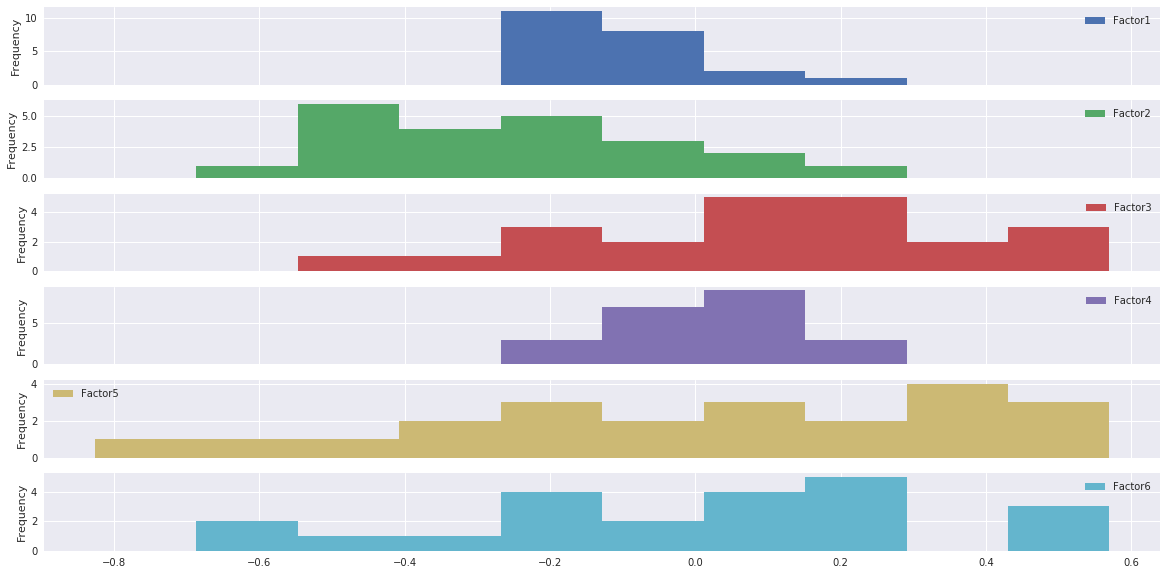

In [28]:
# check for normality of the difference of loadings -> look normal. paired t-test valid
diff=skel_loadings - fullscene_loadings
diff.plot(kind="hist",subplots=True)



In [29]:
for k in diff.columns: print("%s: %s" % (k,stats.ttest_rel(skel_loadings[k], fullscene_loadings[k])))

Factor1: Ttest_relResult(statistic=-3.340473578758402, pvalue=0.003102025082825061)
Factor2: Ttest_relResult(statistic=-5.2787717162173795, pvalue=3.112555723213701e-05)
Factor3: Ttest_relResult(statistic=1.9010181731166875, pvalue=0.07111205897753953)
Factor4: Ttest_relResult(statistic=1.1000216074992288, pvalue=0.28377330526655475)
Factor5: Ttest_relResult(statistic=0.2560956043915937, pvalue=0.800368978106843)
Factor6: Ttest_relResult(statistic=-0.07273961784126144, pvalue=0.9427016896887795)


In [30]:
for k in diff.columns: print("%s: %s" % (k,stats.wilcoxon(diff[k])))

Factor1: WilcoxonResult(statistic=36.0, pvalue=0.003301864483880959)
Factor2: WilcoxonResult(statistic=17.0, pvalue=0.00037799533287222436)
Factor3: WilcoxonResult(statistic=70.0, pvalue=0.06660810358411856)
Factor4: WilcoxonResult(statistic=91.0, pvalue=0.24910310970315597)
Factor5: WilcoxonResult(statistic=113.0, pvalue=0.661178771669188)
Factor6: WilcoxonResult(statistic=125.0, pvalue=0.9611595909257591)


## Clustering

In [31]:
from sklearn.cluster import KMeans

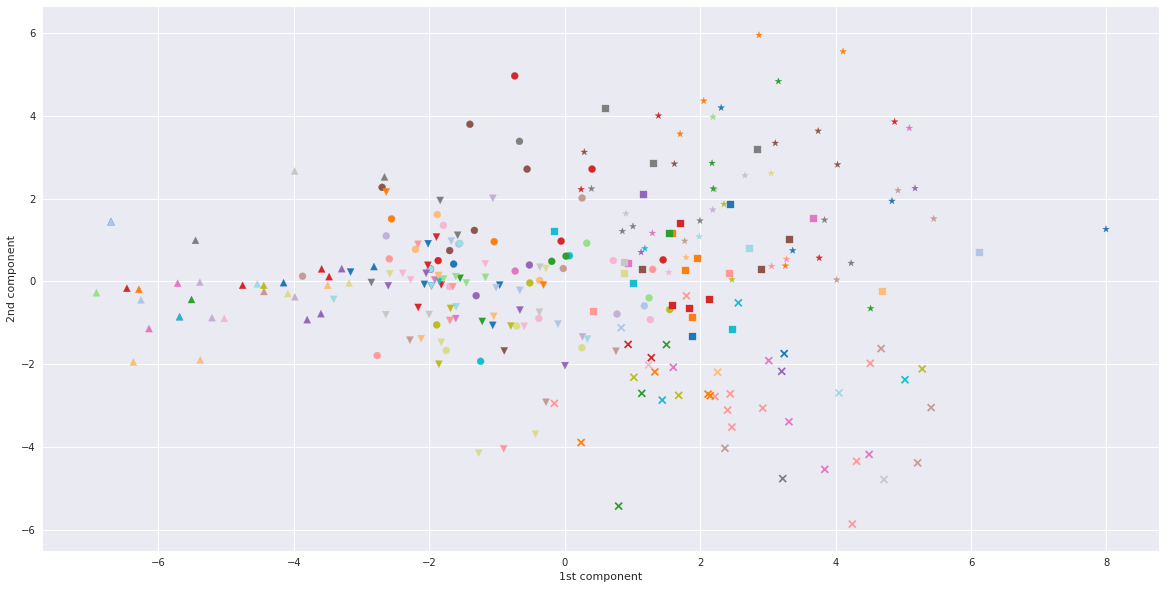

In [32]:
# kMeans clustering after PCA-based dimensionality reduction
# the number of clusters is essentially arbitrary
skel_clustering_data=skel_pca
skel_kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(skel_clustering_data)
plot_embedding(skel_clustering_data,skel_labels, clusters=skel_kmeans, three_d=False)

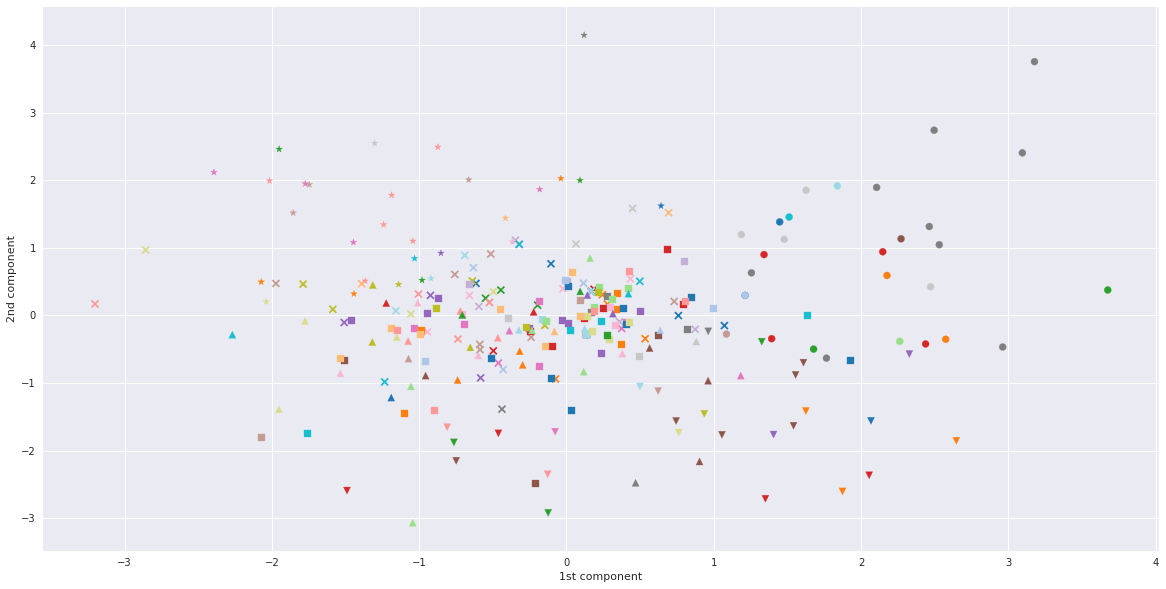

In [33]:
# kMeans clustering after LDA-based dimensionality reduction
skel_clustering_data=skel_lda
fullscene_clustering_data=fullscene_lda

skel_kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(skel_clustering_data)
fullscene_kmeans_model = KMeans(n_clusters=6, random_state=0).fit(fullscene_clustering_data)
fullscene_kmeans = fullscene_kmeans_model.predict(fullscene_clustering_data)

plot_embedding(skel_clustering_data,skel_labels, clusters=skel_kmeans, three_d=False)

In [34]:
skel_clipPerClusters_df=pd.DataFrame()
fullscene_clipPerClusters_df=pd.DataFrame()

for i in skel_kmeans:
    skel_clipPerClusters_df[i] = skel_df[skel_kmeans == i]["clipName"].value_counts()
    
for i in fullscene_kmeans:
    fullscene_clipPerClusters_df[i] = fullscene_df[fullscene_kmeans == i]["clipName"].value_counts()

clipPerClusters_df=pd.concat([skel_clipPerClusters_df.T, fullscene_clipPerClusters_df.T], sort=False, keys=["skel", "fullscene"]).T
#clipPerClusters_df.T.plot(kind='bar')

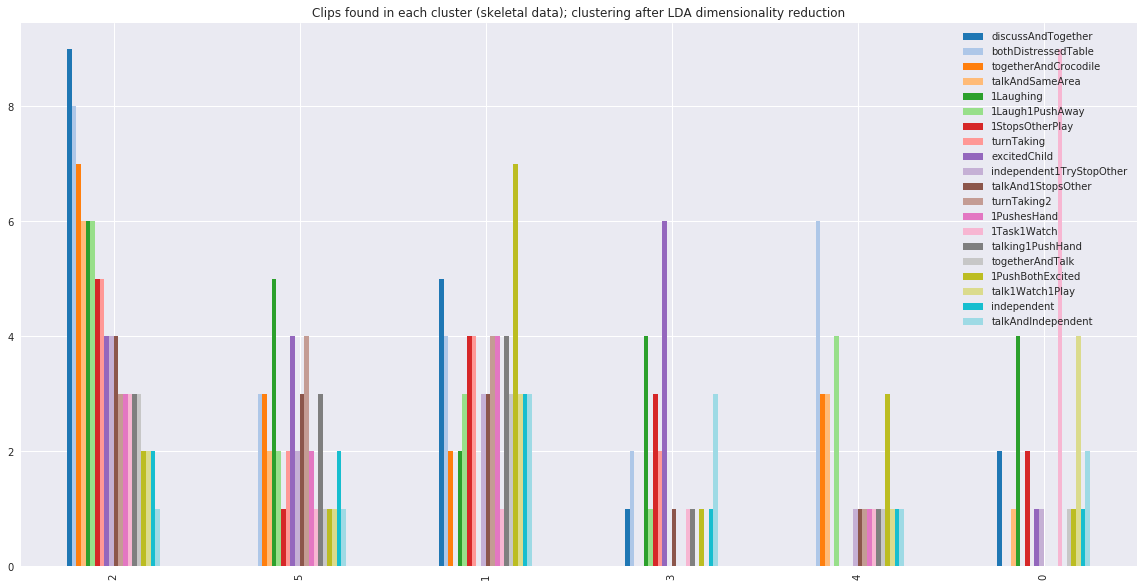

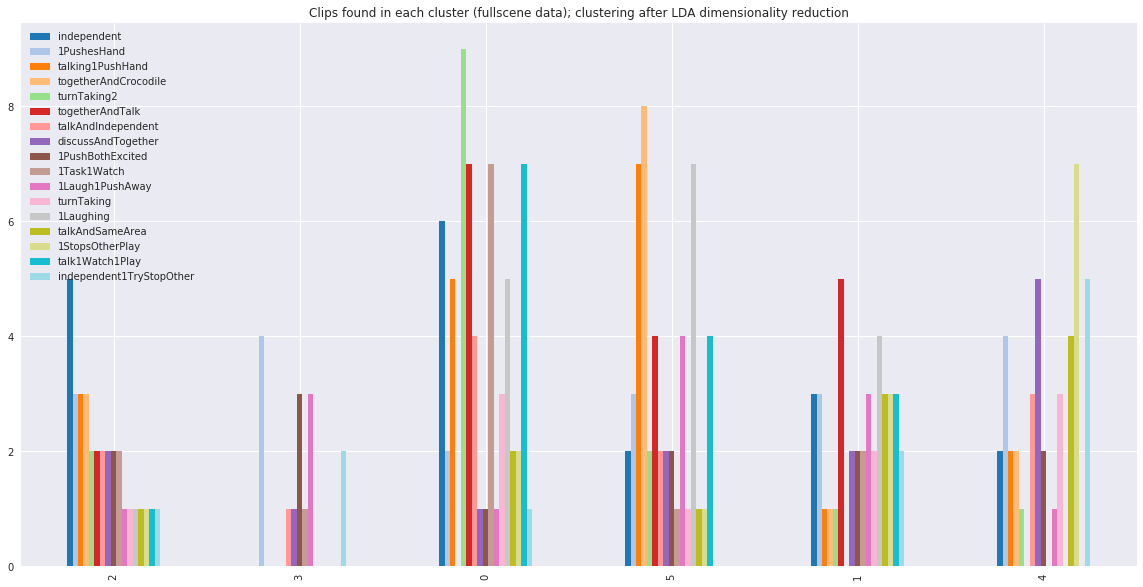

In [35]:
skel_clipPerClusters_df.T.plot(kind='bar', cmap=plt.get_cmap("tab20"), title="Clips found in each cluster (skeletal data); clustering after LDA dimensionality reduction")
fullscene_clipPerClusters_df.T.plot(kind='bar', cmap=plt.get_cmap("tab20"), title="Clips found in each cluster (fullscene data); clustering after LDA dimensionality reduction")

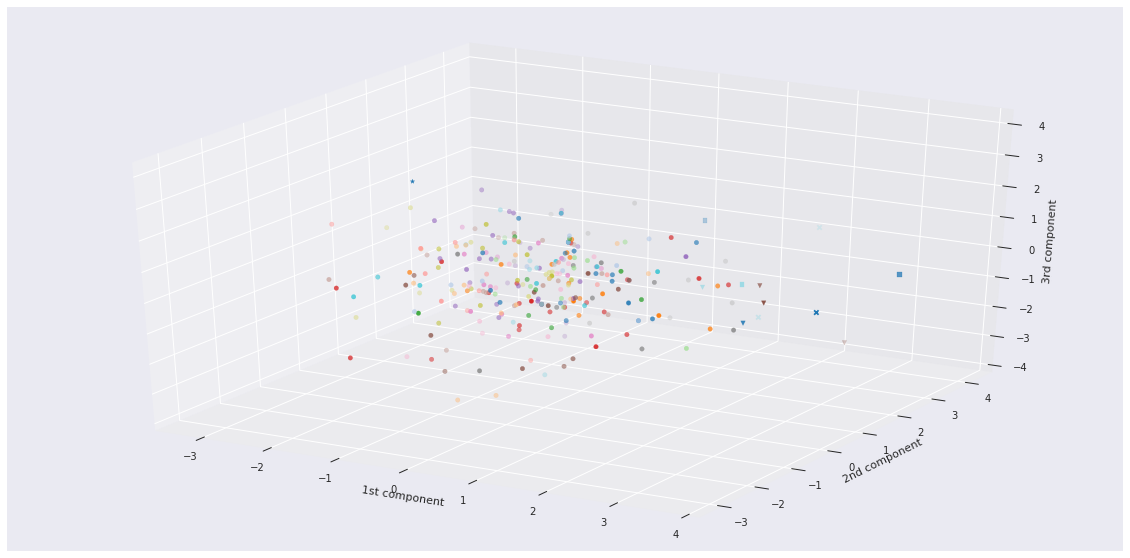

In [36]:
# using MeanShift to estimate the number of cluster is not very effective on such a distribution
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(skel_clustering_data, quantile=0.2)
skel_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(skel_clustering_data)
plot_embedding(skel_clustering_data,skel_labels, clusters=skel_ms, three_d=True)



# Classification

In [37]:
from sklearn import svm

In [38]:
clf = svm.SVC(kernel='rbf')

# trying with skel, skel_pca, skel_lda do not lead to any clear improvements
training_set = fullscene_lda
#training_labels = skel_labels
training_labels = fullscene_kmeans

testing_set = skel_lda
#testing_labels = fullscene_labels
testing_labels = fullscene_kmeans_model.predict(skel_lda)

clf.fit(training_set, training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
for p, l in zip(clf.predict(testing_set), testing_labels):
    print("%s (should be %s)" % (p,l))

4 (should be 4)
4 (should be 4)
5 (should be 5)
2 (should be 2)
1 (should be 1)
3 (should be 3)
0 (should be 3)
3 (should be 3)
0 (should be 0)
2 (should be 2)
0 (should be 4)
5 (should be 5)
4 (should be 4)
0 (should be 0)
2 (should be 2)
0 (should be 2)
0 (should be 0)
1 (should be 1)
1 (should be 1)
0 (should be 0)
0 (should be 0)
2 (should be 2)
5 (should be 5)
0 (should be 0)
1 (should be 1)
0 (should be 0)
0 (should be 0)
5 (should be 5)
2 (should be 2)
1 (should be 1)
0 (should be 0)
0 (should be 0)
5 (should be 5)
5 (should be 5)
0 (should be 0)
0 (should be 0)
0 (should be 0)
1 (should be 1)
3 (should be 3)
4 (should be 4)
2 (should be 2)
0 (should be 3)
5 (should be 5)
2 (should be 2)
0 (should be 4)
2 (should be 2)
1 (should be 4)
0 (should be 0)
4 (should be 4)
4 (should be 4)
0 (should be 0)
2 (should be 2)
2 (should be 2)
0 (should be 0)
2 (should be 2)
4 (should be 4)
2 (should be 2)
0 (should be 0)
5 (should be 5)
4 (should be 4)
4 (should be 4)
5 (should be 5)
2 (shoul

In [40]:
print("SVM: %.1f%% successful prediction out of %d tested clips" % (clf.score(testing_set, testing_labels) * 100, len(testing_labels)))

SVM: 91.7% successful prediction out of 276 tested clips


In [41]:
import itertools
def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


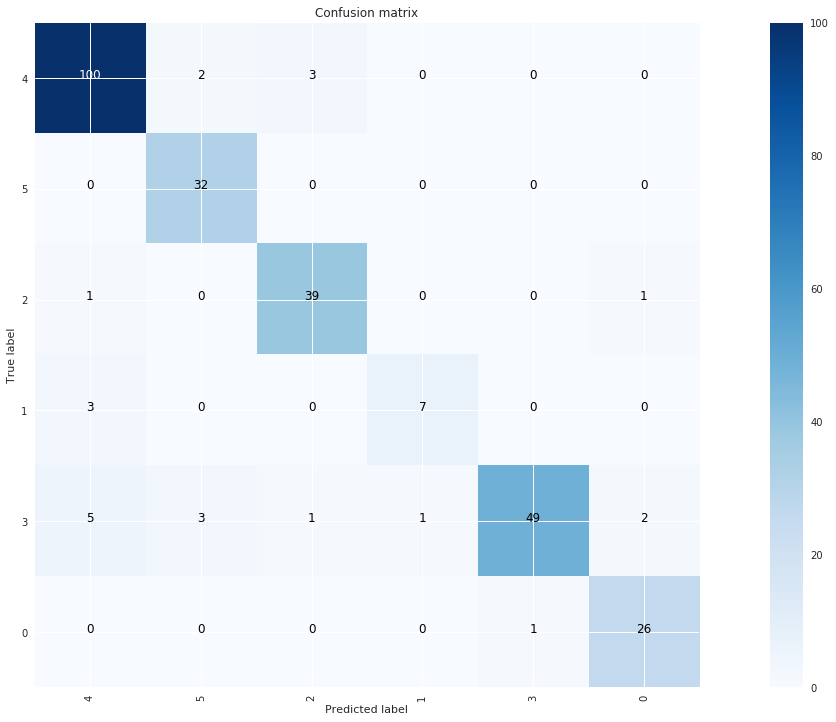

In [42]:
from sklearn.metrics import confusion_matrix


cnf_matrix = confusion_matrix(testing_labels, clf.predict(testing_set))
plot_confusion_matrix(cnf_matrix, classes=pd.unique(testing_labels))